In [1]:
#import matplotlib.pyplot as plt # for plotting maps
import pandas as pd 
import geopandas as gp 
import os
from zipfile import ZipFile
import zipfile
import shutil
import requests
import sys
from jinja2 import Environment, FileSystemLoader

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None) 

# External Validation

In [5]:
#FUNCTIONs THAT COMPLETE THE COMPARISONS

#Identify population columns from file
def get_pop_cols(df):
    return {c for c in df.columns if (c.startswith('P0') | c.startswith('H0'))}

#Collect population columns from datasets being compared
def get_valid_pop_cols(df1, df2):
    df1_pop_cols = get_pop_cols(df1)
    df2_pop_cols = get_pop_cols(df2)
    pop_cols = df1_pop_cols.intersection(df2_pop_cols)
    print("There are {} pop cols".format(len(pop_cols)))
    diff = df1_pop_cols.symmetric_difference(df2_pop_cols)
    #if (len(diff) > 0):
    #    print('WARN there are {} columns in one df not in the other: '.format(len(diff), diff))
    #else:
    #    print("INFO all pop column headers matched between the dataframes")
    return pop_cols

#Compare valid columns
def check(df1, df2, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEOID'):
    valid_pop_cols = get_valid_pop_cols(df1, df2)
    match = []
    not_match = []
    for index, row in df1.iterrows():
        census_geography_name_df1 = row[census_geography_column_name_df1]
        #print("Check GEOID: ", census_geography_name_df1)
        for pop_col in valid_pop_cols:
            #print("Checking pop_col:", pop_col)
            df1_val = row[pop_col]
            #census_geog_column_name is a string of all of the values in the NAME column
            #so df2[census_Geog_column] is a series of all geographies 
            df2_series = df2[df2[census_geography_column_name_df2] == census_geography_name_df1][pop_col]
            if df2_series.shape[0] == 1:
                df2_val = df2_series.iloc[0]
            else:
                continue
            if df1_val == df2_val:
                match.append(pop_col)
                #print(pop_col, ' count does match!', df1_val, '==', df2_val)
            else:
                not_match.append(pop_col)
                print('WARN - ', census_geography_name_df1, pop_col, ' count DO NOT MATCH', df1_val, '!=', df2_val)
    if (not_match == [])&(match!=[]):
        print('dataframes match!')
    else:
        print('WARN - dataframes DO NOT MATCH')
        return not_match

### Comparison with VEST/ALARM:

In [3]:
to_compare_vest = {'_2020_vtd.csv':'_pl2020_vtd'}#, '_2020_block.csv':'_pl2020_b'}
vest_col_adjust_dict = {'pop':'P0010001','pop_hisp':'P0020002','pop_white':'P0020005','pop_black':'P0020006','pop_aian':'P0020007',
                        'pop_asian':'P0020008','pop_nhpi':'P0020009','pop_other':'P0020010','pop_two':'P0020011',
                        'vap':'P0040001','vap_hisp':'P0040002','vap_white':'P0040005','vap_black':'P0040006','vap_aian':'P0040007',
                        'vap_asian':'P0040008','vap_nhpi':'P0040009','vap_other':'P0040010','vap_two':'P0040011'}

In [8]:
rdh_or_b = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_vest_alarm/or_pl2020_b/or_pl2020_b.csv')
vest_or_b = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/from_vest_alarm/or_2020_block.csv')
vest_or_b.rename(columns = vest_col_adjust_dict, inplace = True) 
check(rdh_or_b, vest_or_b, census_geography_column_name_df1='GEOID20', census_geography_column_name_df2='GEOID20')

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (29,31,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 18 pop cols
dataframes match!


In [6]:
rdh_pa_vtd = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_vest_alarm/pa_pl2020_vtd/pa_pl2020_vtd.csv')
vest_pa_vtd = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/from_vest_alarm/pa_2020_vtd.csv')
vest_pa_vtd.rename(columns = vest_col_adjust_dict, inplace = True) 
check(rdh_pa_vtd, vest_pa_vtd, census_geography_column_name_df1='GEOID20', census_geography_column_name_df2='GEOID20')

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (8,20,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 18 pop cols
dataframes match!


In [7]:
vest_states = ['TX', 'VA', 'WI', 'OH', 'PA']

# VEST election result comparison
rdh_filepath = '/Users/lilyfalk/PL_2020/lily_verification/rdh_for_vest_alarm/'
partner_filepath = '/Users/lilyfalk/PL_2020/lily_verification/from_vest_alarm/'
for key in to_compare_vest.keys(): 
    val = to_compare_vest.get(key)
    for state in vest_states:
        state_abrv = state.lower()
        partner_file = pd.read_csv(partner_filepath + state_abrv+key)
        partner_file.rename(columns = vest_col_adjust_dict, inplace = True) 
        #partner_df = partner_file[partner_file['STUSAB']==state]
        print('Checking: ', key, ' ',state)
        for rdh_file in os.listdir(rdh_filepath + state_abrv + val):
            if not rdh_file == 'README.txt':
                rdh_file = pd.read_csv(rdh_filepath + state_abrv + val + '/' + rdh_file)
                check(rdh_file, partner_file, census_geography_column_name_df1='GEOID20', census_geography_column_name_df2='GEOID20')


Checking:  _2020_vtd.csv   TX
There are 18 pop cols
dataframes match!
Checking:  _2020_vtd.csv   VA
There are 18 pop cols
dataframes match!
Checking:  _2020_vtd.csv   WI
There are 18 pop cols
dataframes match!
Checking:  _2020_vtd.csv   OH
There are 18 pop cols
dataframes match!
Checking:  _2020_vtd.csv   PA
There are 18 pop cols


/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (8,20,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


dataframes match!


### Comparison with Steven Ochoa Data:

In [9]:
#Dictionaries to provide key value pairs between Ochoa naming convention and RDH
to_compare = {'County_US_legacy_formatted_short.csv':'_pl2020_cnty',
             'State_US_legacy_formatted_short.csv':'_pl2020_st',
             'Place_US_legacy_formatted_short.csv':'_pl2020_place',
             'StateLower_US_legacy_formatted_short.csv':'_pl2020_sldl',
             'StateUpper_US_legacy_formatted_short.csv':'_pl2020_sldu',
             'Congress_US_legacy_formatted_short.csv':'_pl2020_cd'}

to_compare_al = {'County_al_legacy_formatted_short.csv':'_pl2020_cnty',
             'State_al_legacy_formatted_short.csv':'_pl2020_st',
             'Place_al_legacy_formatted_short.csv':'_pl2020_place',
             'StateLower_al_legacy_formatted_short.csv':'_pl2020_sldl',
             'StateUpper_al_legacy_formatted_short.csv':'_pl2020_sldu',
             'Congress_al_legacy_formatted_short.csv':'_pl2020_cd'}
#This is where Peter got these names from (~page 99): 
#https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/summary-file/2020Census_PL94_171Redistricting_StatesTechDoc_English.pdf
col_adjustment_dict = {
'PL2020_Population':'P0010001',
    'PL2020_Hispanic_Origin':'P0020002', 
    'PL2020_Not_Hispanic':'P0020003',
    'PL2020_NH_1_Race':'P0020004',
    'PL2020_NH_Wht':"P0020005", 
    'PL2020_NH_Blk':"P0020006", 
    'PL2020_NH_Ind':"P0020007", 
    'PL2020_NH_Asn':"P0020008",
    'PL2020_NH_Hwn':"P0020009",
    'PL2020_NH_Oth':"P0020010",
    'PL2020_NH_2plus_Races':"P0020011",
    'PL2020_NH_3_Races':"P0020028", 
    'PL2020_NH_4_Races':"P0020049", 
    'PL2020_NH_5_Races':"P0020065",
    'PL2020_NH_6_Races':"P0020072",
    'PL2020_18_Pop':"P0040001", 
    'PL2020_H18_Pop':"P0040002",
    'PL2020_NH18_Pop':"P0040003", 
    'PL2020_NH18_1_Race':"P0040004",
    'PL2020_NH18_Wht':"P0040005",
    'PL2020_NH18_Blk':"P0040006",
    'PL2020_NH18_Ind':"P0040007",
    'PL2020_NH18_Asn':"P0040008",
    'PL2020_NH18_Hwn':"P0040009", 
    'PL2020_NH18_Oth':"P0040010", 
    'PL2020_NH18_2plus_Races':"P0040011",
    'PL2020_NH18_2_Races':"P0040012", 
    'PL2020_NH18_3_Races':"P0040028", 
    'PL2020_NH18_4_Races':"P0040049",
    'PL2020_NH18_5_Races':"P0040065",
    'PL2020_NH18_6_Races':"P0040072",
    'PL2020_HH':"H0010001",
    'PL2020_HH_Occupied':"H0010002",
    'PL2020_HH_Vacant':"H0010003",
    'PL2020_People_in_group_quarters':"P0050001", 
    'PL2020_InGrp_Institutionalized':"P0050002",
    'PL2020_InGrp_Adult_Correctional':"P0050003", 
    'PL2020_InGrp_Juvenile':"P0050004",
    'PL2020_InGrp_Nursing':"P0050005", 
    'PL2020_InGrp_Other_Institutionalized':"P0050006",
    'PL2020_InGrp_Noninstitutionalized':"P0050007", 
    'PL2020_InGrp_College_Student':"P0050008",
    'PL2020_InGrp_Military':"P0050009", 
    'PL2020_InGrp_Other_Noninstitutionalized':"P0050010"}

In [10]:
# Ochoa - Multi-State Comparison
states = ['AZ','FL','GA','LA','MI','MO','MS','NC']
rdh_filepath = '/Users/lilyfalk/PL_2020/lily_verification/rdh_files/csvs_unzipped/rdh_processed_csvs/'
partner_filepath = '/Users/lilyfalk/PL_2020/lily_verification/partner_files/reredistrictingdatahubprocessedalfiles/'
for key in to_compare.keys():
    partner_file = pd.read_csv(partner_filepath + key)
    partner_file.rename(columns = col_adjustment_dict, inplace = True)  
    val = to_compare.get(key)
    for state in states:
        state_abrv = state.lower()
        partner_df = partner_file[partner_file['STUSAB']==state]
        print('Checking: ', key, ' ',state)
        for rdh_file in os.listdir(rdh_filepath + state_abrv + val):
            if not rdh_file == 'README.txt':
                rdh_file = pd.read_csv(rdh_filepath + state_abrv + val + '/' + rdh_file)
                check(rdh_file, partner_df)


Checking:  County_US_legacy_formatted_short.csv   AZ
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   FL
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   GA
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   LA
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   MI
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   MO
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   MS
There are 44 pop cols
dataframes match!
Checking:  County_US_legacy_formatted_short.csv   NC
There are 44 pop cols
dataframes match!
Checking:  State_US_legacy_formatted_short.csv   AZ
There are 44 pop cols
dataframes match!
Checking:  State_US_legacy_formatted_short.csv   FL
There are 44 pop cols
dataframes match!
Checking:  State_US_legacy_formatted_short.csv   GA
There are 44 pop col

In [11]:
# Ochoa - AL Comparison - RDH Place file modified to create bad numbers in 2 spots to check for error case
## (this check completed in addition to checking that the numbers do match)
states = ['AL']
rdh_filepath = '/Users/lilyfalk/PL_2020/lily_verification/rdh_files/csvs_unzipped/al_rdh_processed_csvs/'
partner_filepath = '/Users/lilyfalk/PL_2020/lily_verification/partner_files/csvs_unzipped/fwdal2020pldata/'
for key in to_compare_al.keys():
    partner_file = pd.read_csv(partner_filepath + key)
    partner_file.rename(columns = col_adjustment_dict, inplace = True)  
    val = to_compare_al.get(key)
    for state in states:
        state_abrv = state.lower()
        partner_df = partner_file[partner_file['STUSAB']==state]
        print('Checking: ', key, ' ',state)
        for rdh_file in os.listdir(rdh_filepath + state_abrv + val):
            if not rdh_file == 'README.txt':
                rdh_file = pd.read_csv(rdh_filepath + state_abrv + val + '/' + rdh_file)
                check(rdh_file, partner_df)
'''SEE NOTE AT TOP --- THIS SHOULD RETURN:
WARN -  1600000US0100100 P0010001  count DO NOT MATCH 0 != 133
WARN -  1600000US0102836 P0010001  count DO NOT MATCH 0 != 2246
^ To be expected to test the function to make sure working.'''

Checking:  County_al_legacy_formatted_short.csv   AL
There are 44 pop cols
dataframes match!
Checking:  State_al_legacy_formatted_short.csv   AL
There are 44 pop cols
dataframes match!
Checking:  Place_al_legacy_formatted_short.csv   AL
There are 44 pop cols
WARN -  1600000US0100100 P0010001  count DO NOT MATCH 0 != 133
WARN -  1600000US0102836 P0010001  count DO NOT MATCH 0 != 2246
WARN - dataframes DO NOT MATCH
Checking:  StateLower_al_legacy_formatted_short.csv   AL
There are 44 pop cols
dataframes match!
Checking:  StateUpper_al_legacy_formatted_short.csv   AL
There are 44 pop cols
dataframes match!
Checking:  Congress_al_legacy_formatted_short.csv   AL
There are 44 pop cols
dataframes match!


### Comparison with MGGG

In [12]:
#Dictionary to make MGGG cols match RDH cols
mggg_col_adjust = {'TOTPOP':'P0020001',
'WHITE':'P0020005',
'BLACK':'P0020006',
'AMIN':'P0020007',
'ASIAN':'P0020008',
'NHPI':'P0020009',
'OTHER':'P0020010',
'2MORE':'P0020011',
'HISP':'P0020002',
'VAP':'P0040001',
'WVAP':'P0040005',
'BVAP':'P0040006',
'AMINVAP':'P0040007',
'ASIANVAP':'P0040008',
'NHPIVAP':'P0040009',
'OTHERVAP':'P0040010',
'2MOREVAP':'P0040011',
'HVAP':'P0040002'}

#Dictionary for key value pairs between MGGG file naming convention and RDH
to_compare_mggg = {'DaneCty_WI.csv':'WI_DANE_COUNTY.csv', 'GAstate.csv':'GA_STATE.csv', 'LambertvilleMI.csv':'MI_LAMBERTVILLE.csv',
                   'MOsldu_13.csv':'MO_13_SLDU.csv',
                   'TXsldl_75.csv':'TX_75_SLDL.csv', 'MI_CD1.csv':'MI_1_CONGRESSIONAL.csv'}

In [13]:
# MGGG
rdh_filepath = '/Users/lilyfalk/PL_2020/check/rdh_mggg_states/csv/'
partner_filepath = '/Users/lilyfalk/PL_2020/check/from_mggg/csv/'
for key in to_compare_mggg.keys():
    partner_file = pd.read_csv(partner_filepath + key)
    partner_file.rename(columns = mggg_col_adjust, inplace = True)                   
    for val in to_compare_mggg.values():
        if to_compare_mggg.get(key) == val:
            #print(val)
            rdh_file = pd.read_csv(rdh_filepath + val)
            check(rdh_file, partner_file, census_geography_column_name_df1 = 'NAME', census_geography_column_name_df2 = 'NAME20')

There are 18 pop cols
dataframes match!
There are 18 pop cols
dataframes match!
There are 18 pop cols
dataframes match!
There are 18 pop cols
dataframes match!
There are 18 pop cols
dataframes match!
There are 18 pop cols
dataframes match!


## SHAPEFILE - MGGG comparison

In [14]:
def shp_validation_variable_defining_and_geom_almost_equals_check(rdh_gdf, partner_gdf, match_column):
    shp_gdfv_merge = pd.merge(rdh_gdf, partner_gdf, on = match_column, how = 'outer', suffixes = ['_x', '_y'], indicator = True)
    #shp_gdfv_merge = shp_gdfv_merge.reset_index()

    both = shp_gdfv_merge[shp_gdfv_merge["_merge"]=="both"]
    #both.reset_index(drop=True,inplace=True)
    global rdh_geoms
    rdh_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=rdh_gdf.crs)
    global partner_geoms
    partner_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=rdh_gdf.crs)
    rdh_geoms = rdh_geoms.to_crs(3857)
    partner_geoms = partner_geoms.to_crs(3857)
    rdh_geoms["geometry_x"]=rdh_geoms.buffer(0)
    partner_geoms["geometry_y"]=partner_geoms.buffer(0)
    vals = rdh_geoms.geom_almost_equals(partner_geoms,decimal=0)
    print('geom_almost_equals value counts: ', vals.value_counts())

def geog_area_difference_plot(rdh_geoms, partner_geoms, match_column):
    count = 0
    global area_list
    area_list = []
    big_diff = pd.DataFrame(columns=["area"])
    print('AREA DIFFERENCES PLOTTED BELOW')
    for i in range(0,len(rdh_geoms)):
        diff = rdh_geoms.iloc[[i]].symmetric_difference(partner_geoms.iloc[[i]])
        intersection = rdh_geoms.iloc[[i]].intersection(partner_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)
        #print("Area is " + str(area))

        if (area > 1):
            count += 1
            name = rdh_geoms.at[i,match_column]
            big_diff.loc[name]=area
            print(str(count)+") For rdh: " + name + ', partner: '+ partner_geoms.at[i,match_column]+ " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                rdh_geoms.iloc[[i]].plot(color="orange",ax=base)
                partner_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                rdh_geoms.iloc[[i]].plot(color="orange",ax=base)
                partner_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                
def geog_area_difference_list(area_list):
    df = pd.DataFrame(area_list)
    print('AREA DIFFERENCES PRINTED BELOW')
    print(df.shape)

    print(str(len(df[df[0]==0]))+" geometry w/ a difference of 0 km^2")
    print(str(len(df[(df[0]>0)]))+ " geometries w/ a difference greater than 0")

def shp_total_validation(rdh_gdf, partner_gdf, match_column):
    shp_validation_variable_defining_and_geom_almost_equals_check(rdh_gdf, partner_gdf, match_column)
    geog_area_difference_plot(rdh_geoms, partner_geoms, match_column)
    geog_area_difference_list(area_list)
    rdh_gdf.plot()
    partner_gdf.plot()

In [15]:
to_compare_mggg_shp = {'DaneCty_WI':'WI_DANE_COUNTY', 'GAstate':'GA_STATE', 'LambertvilleMI':'MI_LAMBERTVILLE',
                   'MOsldu_13':'MO_13_SLDU',
                   'TXsldl_75':'TX_75_SLDL', 'MI_CD1':'MI_1_CONGRESSIONAL'}

WI_DANE_COUNTY
geom_almost_equals value counts:  True    1
dtype: int64
AREA DIFFERENCES PLOTTED BELOW
AREA DIFFERENCES PRINTED BELOW
(1, 1)
1 geometry w/ a difference of 0 km^2
0 geometries w/ a difference greater than 0
GA_STATE
geom_almost_equals value counts:  True    1
dtype: int64
AREA DIFFERENCES PLOTTED BELOW
AREA DIFFERENCES PRINTED BELOW
(1, 1)
1 geometry w/ a difference of 0 km^2
0 geometries w/ a difference greater than 0
MI_LAMBERTVILLE
geom_almost_equals value counts:  True    1
dtype: int64
AREA DIFFERENCES PLOTTED BELOW
AREA DIFFERENCES PRINTED BELOW
(1, 1)
1 geometry w/ a difference of 0 km^2
0 geometries w/ a difference greater than 0
MO_13_SLDU
geom_almost_equals value counts:  True    1
dtype: int64
AREA DIFFERENCES PLOTTED BELOW
AREA DIFFERENCES PRINTED BELOW
(1, 1)
1 geometry w/ a difference of 0 km^2
0 geometries w/ a difference greater than 0
TX_75_SLDL
geom_almost_equals value counts:  True    1
dtype: int64
AREA DIFFERENCES PLOTTED BELOW
AREA DIFFERENCES PRINT

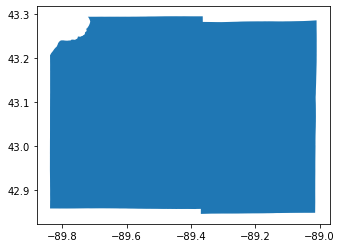

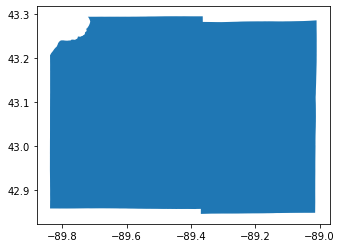

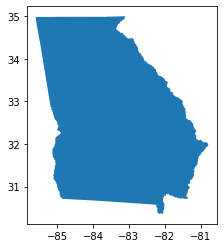

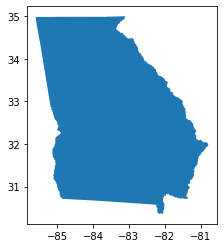

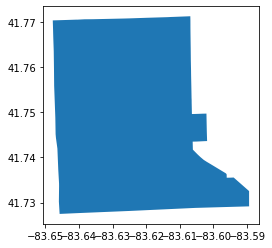

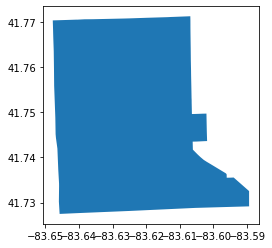

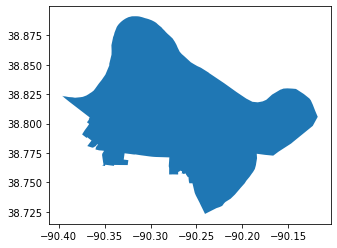

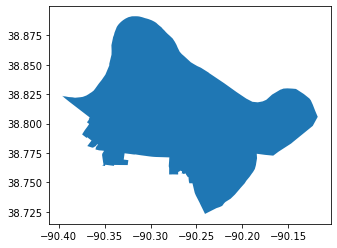

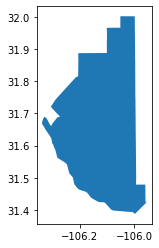

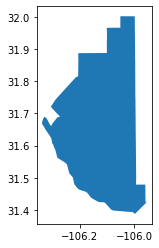

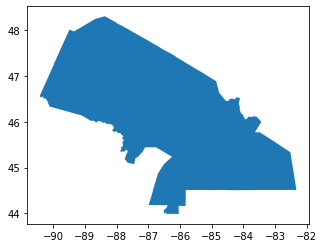

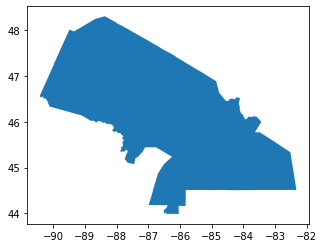

In [16]:
rdh_filepath = '/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/'
partner_filepath = '/Users/lilyfalk/PL_2020/check/from_mggg/shp/'

for key in to_compare_mggg_shp.keys():
    partner_shp = gp.read_file(partner_filepath + key + '/' + key + '.shp')
    if key == 'GAstate':
        partner_shp['NAME'] = partner_shp['NAME20']
    else:
        partner_shp['NAME'] = partner_shp['NAMELSAD20']
    for val in to_compare_mggg_shp.values():
        if to_compare_mggg_shp.get(key) == val:
            print(val)
            rdh_shp = gp.read_file(rdh_filepath + val + '/' + val + '.shp')
            shp_total_validation(rdh_shp, partner_shp, 'NAME')
   

## Census Data Retrieval - 9/16/21

In [54]:
#Function to make population columns numeric to enable comparison
def pop_cols_to_numeric(census_df):
    global census_pop_cols
    census_pop_cols = list(census_df.columns[census_df.columns.map(lambda x: ('P' in x)|(x.startswith('H')))])
    census_df.loc[1:, census_pop_cols] = census_df.loc[1:, census_pop_cols].apply(pd.to_numeric)
    census_df = census_df
    return census_df

#Fxn - grab population columns and modify names
def change_census_col_names(census_df):
    census_pop_cols = list(census_df.columns[census_df.columns.map(lambda x: ('P' in x)|(x.startswith('H')))])
    census_pop_col_dict = {}
    for i in range(len(census_pop_cols)):
        census_pop_col_dict[census_pop_cols[i]] = census_pop_cols[i].replace('P', 'P00').replace('H', 'H00').replace('_', '0').replace('N','')
    census_df.rename(columns = census_pop_col_dict, inplace = True) 

### Load data in from API

I downloaded a table for each variable table as this seemed the easiest way to load in all variables at once for each category... Then I pasted the values into a new cell in case I ever need the variables but do not have the files. Note that in order to use the Census API, the maximum number of variables is 50, but p1-p4 have more than that which makes API use a little inconvenient...

In [27]:
#Variable fields
p1_cols = list(pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P1_2021-09-17T090241/DECENNIALPL2020.P1_data_with_overlays_2021-09-16T174926.csv').columns)
p2_cols = list(pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P2_2021-09-21T162710-place_tract_sldu/DECENNIALPL2020.P2_data_with_overlays_2021-09-21T162659.csv').columns)
p3_cols = list(pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P3_2021-09-22T120549_co_vtd/DECENNIALPL2020.P3_data_with_overlays_2021-09-22T120544.csv').columns)
p4_cols = list(pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P4_2021-09-22T125814/DECENNIALPL2020.P4_data_with_overlays_2021-09-22T125803.csv').columns)
p5_cols = list(pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P5_2021-09-22T125952/DECENNIALPL2020.P5_data_with_overlays_2021-09-22T125945.csv').columns)
h1_cols = list(pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.H1_2021-09-22T130106/DECENNIALPL2020.H1_data_with_overlays_2021-09-22T130056.csv').columns)

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
#Variable fields
p1_cols = ['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N', 'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N', 'P1_010N', 'P1_011N', 'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N', 'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N', 'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N', 'P1_028N', 'P1_029N', 'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N', 'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N', 'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 'P1_047N', 'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N', 'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N', 'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N', 'P1_064N', 'P1_065N', 'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N', 'P1_070N', 'P1_071N']
p2_cols = ['GEO_ID', 'NAME', 'P2_001N', 'P2_002N', 'P2_003N', 'P2_004N', 'P2_005N', 'P2_006N', 'P2_007N', 'P2_008N', 'P2_009N', 'P2_010N', 'P2_011N', 'P2_012N', 'P2_013N', 'P2_014N', 'P2_015N', 'P2_016N', 'P2_017N', 'P2_018N', 'P2_019N', 'P2_020N', 'P2_021N', 'P2_022N', 'P2_023N', 'P2_024N', 'P2_025N', 'P2_026N', 'P2_027N', 'P2_028N', 'P2_029N', 'P2_030N', 'P2_031N', 'P2_032N', 'P2_033N', 'P2_034N', 'P2_035N', 'P2_036N', 'P2_037N', 'P2_038N', 'P2_039N', 'P2_040N', 'P2_041N', 'P2_042N', 'P2_043N', 'P2_044N', 'P2_045N', 'P2_046N', 'P2_047N', 'P2_048N', 'P2_049N', 'P2_050N', 'P2_051N', 'P2_052N', 'P2_053N', 'P2_054N', 'P2_055N', 'P2_056N', 'P2_057N', 'P2_058N', 'P2_059N', 'P2_060N', 'P2_061N', 'P2_062N', 'P2_063N', 'P2_064N', 'P2_065N', 'P2_066N', 'P2_067N', 'P2_068N', 'P2_069N', 'P2_070N', 'P2_071N', 'P2_072N', 'P2_073N']
p3_cols = ['GEO_ID', 'NAME', 'P3_001N', 'P3_002N', 'P3_003N', 'P3_004N', 'P3_005N', 'P3_006N', 'P3_007N', 'P3_008N', 'P3_009N', 'P3_010N', 'P3_011N', 'P3_012N', 'P3_013N', 'P3_014N', 'P3_015N', 'P3_016N', 'P3_017N', 'P3_018N', 'P3_019N', 'P3_020N', 'P3_021N', 'P3_022N', 'P3_023N', 'P3_024N', 'P3_025N', 'P3_026N', 'P3_027N', 'P3_028N', 'P3_029N', 'P3_030N', 'P3_031N', 'P3_032N', 'P3_033N', 'P3_034N', 'P3_035N', 'P3_036N', 'P3_037N', 'P3_038N', 'P3_039N', 'P3_040N', 'P3_041N', 'P3_042N', 'P3_043N', 'P3_044N', 'P3_045N', 'P3_046N', 'P3_047N', 'P3_048N', 'P3_049N', 'P3_050N', 'P3_051N', 'P3_052N', 'P3_053N', 'P3_054N', 'P3_055N', 'P3_056N', 'P3_057N', 'P3_058N', 'P3_059N', 'P3_060N', 'P3_061N', 'P3_062N', 'P3_063N', 'P3_064N', 'P3_065N', 'P3_066N', 'P3_067N', 'P3_068N', 'P3_069N', 'P3_070N', 'P3_071N']
p4_cols = ['GEO_ID', 'NAME', 'P4_001N', 'P4_002N', 'P4_003N', 'P4_004N', 'P4_005N', 'P4_006N', 'P4_007N', 'P4_008N', 'P4_009N', 'P4_010N', 'P4_011N', 'P4_012N', 'P4_013N', 'P4_014N', 'P4_015N', 'P4_016N', 'P4_017N', 'P4_018N', 'P4_019N', 'P4_020N', 'P4_021N', 'P4_022N', 'P4_023N', 'P4_024N', 'P4_025N', 'P4_026N', 'P4_027N', 'P4_028N', 'P4_029N', 'P4_030N', 'P4_031N', 'P4_032N', 'P4_033N', 'P4_034N', 'P4_035N', 'P4_036N', 'P4_037N', 'P4_038N', 'P4_039N', 'P4_040N', 'P4_041N', 'P4_042N', 'P4_043N', 'P4_044N', 'P4_045N', 'P4_046N', 'P4_047N', 'P4_048N', 'P4_049N', 'P4_050N', 'P4_051N', 'P4_052N', 'P4_053N', 'P4_054N', 'P4_055N', 'P4_056N', 'P4_057N', 'P4_058N', 'P4_059N', 'P4_060N', 'P4_061N', 'P4_062N', 'P4_063N', 'P4_064N', 'P4_065N', 'P4_066N', 'P4_067N', 'P4_068N', 'P4_069N', 'P4_070N', 'P4_071N', 'P4_072N', 'P4_073N']
p5_cols = ['GEO_ID', 'NAME', 'P5_001N', 'P5_002N', 'P5_003N', 'P5_004N', 'P5_005N', 'P5_006N', 'P5_007N', 'P5_008N', 'P5_009N', 'P5_010N']
h1_cols = ['GEO_ID', 'NAME', 'H1_001N', 'H1_002N', 'H1_003N']
#Compile variable fields
census_pop_cols = set(p1_cols+p2_cols+p3_cols+p4_cols+p5_cols+h1_cols)

In [40]:
#Functions to enable interaction with Census API

def get_census_base_url():
    HOST = "https://api.census.gov/data"
    year = "2020"
    dataset = "dec/pl"
    base_url = "/".join([HOST, year, dataset])
    print("BASE URL: ", base_url)
    return base_url

from enum import Enum
from pprint import pprint

# geography.value is the http param for the census api corresponding to that geography
class Geography(Enum):
    PLACE = 'place:*'
    CNTY = 'county:*'
    TRACT = 'tract:*'
##Need to debug grabbing other geographies
#    STATE = 'state:*'
#    BLOCK = 'block code:*'
    
def get_params(variable_lst, geography, fip, CENSUS_API_KEY = '2eeb19ba591457182b8b757f5c860cba21bbe7ec'):
    predicates = {} 
    predicates["get"] = ",".join(variable_lst)
    predicates["for"] = geography.value
    predicates["in"] = "state:" + fip
    predicates["key"] = CENSUS_API_KEY
    print("params: ", predicates)
    return predicates

def spencer_parse_response(response):
    col_names = response.json()[0]        
    data = response.json()[1:]
    print('done collecting data for', fip)
    geoids = []  # initialize geoid vector
    pop_data = pd.DataFrame(columns=col_names, data=data)
    cols = [i for i in pop_data.columns if i not in ["NAME","place","state","county"]]
    for col in cols:
        pop_data[col]=pd.to_numeric(pop_data[col])
    for index, row in pop_data.iterrows():
        # make changes here for tracts
        if geog == 'place':
            geoid = row["state"] + row["place"]
        if geog == 'cnty':
            geoid = row["state"] + row["county"]
        geoids.append(geoid)
    pop_data["GEOID"] = geoids
    return pop_data

def lily_parse_response(json):
    df = pd.DataFrame(json)
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    return df

#Function to get census API data
def get_2020pl_data(fip, geography, variable_lst, CENSUS_API_KEY = '2eeb19ba591457182b8b757f5c860cba21bbe7ec'):
    print('starting to collect data for ' + geography.name + ' ' + fip)
    # Write the result to a response object
    response = requests.get(get_census_base_url(), params=get_params(variable_lst, geography, fip))
    #return response
    #print("Got response: ", response, response.text, response.url)
#    pprint(response.json())
    return lily_parse_response(response.json())
    

In [42]:
#Testing
r = get_2020pl_data('02', Geography.CNTY, ['GEO_ID', 'NAME', 'P1_001N'])
r.head()

#If function above returns error, uncomment the "return response" line, then run the below to get a link to the census with a descriotion of what went wrong.
#r.request.url

starting to collect data for CNTY 02
BASE URL:  https://api.census.gov/data/2020/dec/pl
params:  {'get': 'GEO_ID,NAME,P1_001N', 'for': 'county:*', 'in': 'state:02', 'key': '2eeb19ba591457182b8b757f5c860cba21bbe7ec'}


,GEO_ID,NAME,P1_001N,state,county
1,0500000US02240,"Southeast Fairbanks Census Area, Alaska",6808,02,240
2,0500000US02290,"Yukon-Koyukuk Census Area, Alaska",5343,02,290
3,0500000US02016,"Aleutians West Census Area, Alaska",5232,02,016
4,0500000US02020,"Anchorage Municipality, Alaska",291247,02,020
5,0500000US02060,"Bristol Bay Borough, Alaska",844,02,060


In [29]:
#Compile all variables for given state and geo level to explore how this would be done if were desired
p1first50 = p1_cols[:50]
p1after50 = p1_cols[:1]+p1_cols[50:]
p2first50 = p2_cols[:50]
p2after50 = p2_cols[:1]+p2_cols[50:]
p3first50 = p3_cols[:50]
p3after50 = p3_cols[:1]+p3_cols[50:]
p4first50 = p4_cols[:50]
p4after50 = p4_cols[:1]+p4_cols[50:]

r_p1_1 = get_2020pl_data('02', Geography.CNTY, p1first50)
r_p1_2 = get_2020pl_data('02', Geography.CNTY, p1after50)
r_p2_1 = get_2020pl_data('02', Geography.CNTY, p2first50)
r_p2_2 = get_2020pl_data('02', Geography.CNTY, p2after50)
r_p3_1 = get_2020pl_data('02', Geography.CNTY, p3first50)
r_p3_2 = get_2020pl_data('02', Geography.CNTY, p3after50)
r_p4_1 = get_2020pl_data('02', Geography.CNTY, p4first50)
r_p4_2 = get_2020pl_data('02', Geography.CNTY, p4after50)

ak_counties = pd.concat([r_p1_1, r_p1_2, r_p2_1, r_p2_2, r_p3_1, r_p3_2, r_p4_1, r_p4_2], axis = 1)

starting to collect data for CNTY 02
BASE URL:  https://api.census.gov/data/2020/dec/pl
params:  {'get': 'GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N,P1_009N,P1_010N,P1_011N,P1_012N,P1_013N,P1_014N,P1_015N,P1_016N,P1_017N,P1_018N,P1_019N,P1_020N,P1_021N,P1_022N,P1_023N,P1_024N,P1_025N,P1_026N,P1_027N,P1_028N,P1_029N,P1_030N,P1_031N,P1_032N,P1_033N,P1_034N,P1_035N,P1_036N,P1_037N,P1_038N,P1_039N,P1_040N,P1_041N,P1_042N,P1_043N,P1_044N,P1_045N,P1_046N,P1_047N,P1_048N', 'for': 'county:*', 'in': 'state:02', 'key': '2eeb19ba591457182b8b757f5c860cba21bbe7ec'}
starting to collect data for CNTY 02
BASE URL:  https://api.census.gov/data/2020/dec/pl
params:  {'get': 'GEO_ID,P1_049N,P1_050N,P1_051N,P1_052N,P1_053N,P1_054N,P1_055N,P1_056N,P1_057N,P1_058N,P1_059N,P1_060N,P1_061N,P1_062N,P1_063N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_070N,P1_071N', 'for': 'county:*', 'in': 'state:02', 'key': '2eeb19ba591457182b8b757f5c860cba21bbe7ec'}
starting to collect d

In [31]:
ak_counties['GEO_ID'].head()

,GEO_ID,GEO_ID,GEO_ID,GEO_ID,GEO_ID,GEO_ID,GEO_ID,GEO_ID
1,0500000US02240,0500000US02240,0500000US02240,0500000US02240,0500000US02240,0500000US02240,0500000US02240,0500000US02240
2,0500000US02290,0500000US02290,0500000US02290,0500000US02290,0500000US02290,0500000US02290,0500000US02290,0500000US02290
3,0500000US02016,0500000US02016,0500000US02016,0500000US02016,0500000US02016,0500000US02016,0500000US02016,0500000US02016
4,0500000US02020,0500000US02020,0500000US02020,0500000US02020,0500000US02020,0500000US02020,0500000US02020,0500000US02020
5,0500000US02060,0500000US02060,0500000US02060,0500000US02060,0500000US02060,0500000US02060,0500000US02060,0500000US02060


#### H1 Tract

In [33]:
len(h1_cols)

5

In [ ]:
rdh_id_tract = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/id_pl2020_t/id_pl2020_t.csv')

In [45]:
h1_id_tract = get_2020pl_data('16', Geography.TRACT, h1_cols)

starting to collect data for TRACT 16
BASE URL:  https://api.census.gov/data/2020/dec/pl
params:  {'get': 'GEO_ID,NAME,H1_001N,H1_002N,H1_003N', 'for': 'tract:*', 'in': 'state:16', 'key': '2eeb19ba591457182b8b757f5c860cba21bbe7ec'}


In [46]:
rdh_id_tract.shape

(456, 333)

In [55]:
h1_id_tract.shape
pop_cols_to_numeric(h1_id_tract)
change_census_col_names(h1_id_tract)

check(rdh_id_tract, h1_id_tract, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEO_ID')

There are 3 pop cols
dataframes match!


In [56]:
rdh_id_tract.head()

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,COUNTY,COUNTYCC,COUNTYNS,TRACT,CBSA,MEMI,CSA,METDIV,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,GEOID20,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
0,PLST,ID,140,0,0,0,216,1400000US16001000101,16001000101,4,8,16,1779783,1,H1,395066,101,14260,1,147,99999,1573491,145172,1.01,Census Tract 1.01,S,1577,1023,43.612549,-116.209072,CT,16001000101,1577,1439,1235,54,24,83,1,42,138,132,18,36,25,0,47,0,0,0,1,2,0,0,3,0,0,5,0,1,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1577,159,1418,1331,1175,49,17,79,1,10,87,83,12,33,20,0,13,0,0,0,0,2,0,0,3,0,0,4,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1456,1325,1165,36,20,63,1,40,131,126,17,36,20,0,47,0,0,0,1,2,0,0,3,0,0,4,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1456,141,1315,1235,1114,34,13,63,1,10,80,77,11,33,15,0,13,0,0,0,0,2,0,0,3,0,0,3,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1023,889,134,194,0,0,0,0,0,194,0,0,194
1,PLST,ID,140,0,0,0,217,1400000US16001000102,16001000102,4,8,16,1779783,1,H1,395066,102,14260,1,147,99999,2564298,16150,1.02,Census Tract 1.02,S,3261,2288,4

In [57]:
h1_id_tract.head()

,GEO_ID,NAME,H0010001,H0010002,H0010003,state,county,tract
1,1400000US16027021801,"Census Tract 218.01, Canyon County, Idaho",1580,1518,62,16,027,021801
2,1400000US16027021600,"Census Tract 216, Canyon County, Idaho",1752,1669,83,16,027,021600
3,1400000US16027021701,"Census Tract 217.01, Canyon County, Idaho",1634,1584,50,16,027,021701
4,1400000US16027021702,"Census Tract 217.02, Canyon County, Idaho",2358,2296,62,16,027,021702
5,1400000US16027021802,"Census Tract 218.02, Canyon County, Idaho",1207,1165,42,16,027,021802


So, have a way to load in SOME of the geographies via api, and can check from there... But first, before this was sorted out, I downloaded files manually and checked against RDH files, esp since I had to manually download RDH files anyway...

**Note California state level H1 variables compared via Census GUI and RDH csv.**

-----

### Manual download used for actual verification:

#### P1 County

In [18]:
census_county = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P1_2021-09-17T090241/DECENNIALPL2020.P1_data_with_overlays_2021-09-16T174926.csv')
pop_cols_to_numeric(census_county)
change_census_col_names(census_county)

#Subset Census data by state and geolevel
census_al_counties = census_county[census_county['GEO_ID'].map(lambda x: 'US01' in x)]
census_az_counties = census_county[census_county['GEO_ID'].map(lambda x: 'US04' in x)]
census_pa_counties = census_county[census_county['GEO_ID'].map(lambda x: 'US42' in x)]
#Load in RDH data for state and geolevel
rdh_al_counties = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/al_pl2020_cnty.csv')
rdh_az_counties = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/az_pl2020_cnty.csv')
rdh_pa_counties = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/pa_pl2020_cnty.csv')

#Create dicts for easy read in to loop check
census_geos_list_dict = {'al_counties':census_al_counties, 'az_counties':census_az_counties, 'pa_counties':census_pa_counties}
rdh_geos_list_dict = {'al_counties':rdh_al_counties, 'az_counties':rdh_az_counties, 'pa_counties':rdh_pa_counties}
#Loop through to check geogs
for rdh_df_key in rdh_geos_list_dict.keys():
    print(rdh_df_key)
    df1 = rdh_geos_list_dict.get(rdh_df_key)
    for census_df_key in census_geos_list_dict.keys():
        if census_df_key == rdh_df_key:
            print(census_df_key)
            df2 = census_geos_list_dict.get(census_df_key)
            check(df1, df2, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEO_ID')

al_counties
al_counties
There are 71 pop cols
dataframes match!
az_counties
az_counties
There are 71 pop cols
dataframes match!
pa_counties
pa_counties
There are 71 pop cols
dataframes match!


#### P1 Congressional, BG

In [19]:
#Census dataframe for b, bg, usrep for select states
census_geos1 = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P1_2021-09-17T151908/DECENNIALPL2020.P1_data_with_overlays_2021-09-17T151640.csv')
pop_cols_to_numeric(census_geos1)
change_census_col_names(census_geos1)
#Subset by state and geography for comparison
ia_b_p1 = census_geos1[(census_geos1['NAME'].str.contains('Iowa'))&(census_geos1['NAME'].str.slice(start = 6, stop = 11)!='Group')&(census_geos1['NAME'].str.contains('Block'))]
ia_bg_p1 = census_geos1[(census_geos1['NAME'].str.contains('Iowa'))&(census_geos1['NAME'].str.slice(stop = 11)=='Block Group')]
ga_b_p1 = census_geos1[(census_geos1['NAME'].str.contains('Georgia'))&(census_geos1['NAME'].str.slice(start = 6, stop = 11)!='Group')&(census_geos1['NAME'].str.contains('Block'))]
ma_bg_p1 = census_geos1[(census_geos1['NAME'].str.contains('Massachusetts'))&(census_geos1['NAME'].str.slice(stop = 11)=='Block Group')]
ma_usrep_p1 = census_geos1[(census_geos1['NAME'].str.contains('Massachusetts'))&(census_geos1['NAME'].str.contains('Congressional'))]
#rdh dataframes for b, bg, usrep for select states
ia_b_rdh = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ia_pl2020_b/ia_pl2020_b.csv')
ia_bg_rdh = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ia_pl2020_bg/ia_pl2020_bg.csv')
ga_b_rdh = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ga_pl2020_b/ga_pl2020_b.csv')
ma_bg_rdh = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ma_pl2020_bg/ma_pl2020_bg.csv')
ma_usrep_rdh = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ma_pl2020_cd/ma_pl2020_cd.csv')

#Block files too large, computer not able to process, so checked block level on P5 later 
#'ia_b':ia_b_p1, 'ia_b':ia_b_rdh, 'ga_b_p1':ga_b_p1, 'ga_b_p1':ga_b_rdh,

census_geos_list_dict = {'ia_bg':ia_bg_p1, 'ma_bg':ma_bg_p1, 'ma_usrep':ma_usrep_p1}
rdh_geos_list_dict = {'ia_bg':ia_bg_rdh, 'ma_bg':ma_bg_rdh, 'ma_usrep':ma_usrep_rdh}

for rdh_df_key in rdh_geos_list_dict.keys():
    print(rdh_df_key)
    df1 = rdh_geos_list_dict.get(rdh_df_key)
    for census_df_key in census_geos_list_dict.keys():
        if census_df_key == rdh_df_key:
            print(census_df_key)
            df2 = census_geos_list_dict.get(census_df_key)
            check(df1, df2, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEO_ID')

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (29,31,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (20,29,31,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_

ia_bg
ia_bg
There are 71 pop cols
dataframes match!
ma_bg
ma_bg
There are 71 pop cols
dataframes match!
ma_usrep
ma_usrep
There are 71 pop cols
dataframes match!


#### P2 Tract, SLDU, Place

In [20]:
census_p2_geos1 = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P2_2021-09-21T162710-place_tract_sldu/DECENNIALPL2020.P2_data_with_overlays_2021-09-21T162659.csv')
#Change column names to match rdh
change_census_col_names(census_p2_geos1)
#Change pop cols to numeric to enable comparison
pop_cols_to_numeric(census_p2_geos1)

#Subset census geos
id_tract_p2 = census_p2_geos1[census_p2_geos1['NAME'].str.slice(stop = 12)=='Census Tract']
ct_sldu_p2 = census_p2_geos1[census_p2_geos1['NAME'].str.contains('District')]
in_p2_place = census_p2_geos1[(~census_p2_geos1['NAME'].str.contains('District'))&(census_p2_geos1['NAME'].str.slice(stop = 12)!='Census Tract')]#&(census_p2_geos1['NAME'].str.contains('CDP'))]
#Load in RDH data
rdh_id_tract = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/id_pl2020_t/id_pl2020_t.csv')
rdh_ct_sldu = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ct_pl2020_sldu/ct_pl2020_sldu.csv')
rdh_in_place = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/in_pl2020_place.csv')

#Dict for for loop
census_geos_list_dict = {'id_tract':id_tract_p2, 'ct_sldu':ct_sldu_p2, 'in_place':in_p2_place}
rdh_geos_list_dict = {'id_tract':rdh_id_tract, 'ct_sldu':rdh_ct_sldu, 'in_place':rdh_in_place}
#Loop to check geos
for rdh_df_key in rdh_geos_list_dict.keys():
    print(rdh_df_key)
    df1 = rdh_geos_list_dict.get(rdh_df_key)
    for census_df_key in census_geos_list_dict.keys():
        if census_df_key == rdh_df_key:
            print(census_df_key)
            df2 = census_geos_list_dict.get(census_df_key)
            check(df1, df2, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEO_ID')

id_tract
id_tract
There are 73 pop cols
dataframes match!
ct_sldu
ct_sldu
There are 73 pop cols
dataframes match!
in_place
in_place
There are 73 pop cols
dataframes match!


#### P3 VTD

In [21]:
#Load in census CO VTD file
census_p3_vtd = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P3_2021-09-22T120549_co_vtd/DECENNIALPL2020.P3_data_with_overlays_2021-09-22T120544.csv')
change_census_col_names(census_p3_vtd)
pop_cols_to_numeric(census_p3_vtd)
#Load in rdh file for geo and state
rdh_co_vtd = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/co_pl2020_vtd/co_pl2020_vtd.csv')
check(rdh_co_vtd, census_p3_vtd, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEO_ID')

There are 71 pop cols
dataframes match!


#### P4 SLDL

In [22]:
census_p4_geos1 = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P4_2021-09-23T112510_sldl_place_st/DECENNIALPL2020.P4_data_with_overlays_2021-09-23T112501.csv')
change_census_col_names(census_p4_geos1)
pop_cols_to_numeric(census_p4_geos1)
#Subset census file for election
ky_p4_sldl = census_p4_geos1[(census_p4_geos1['NAME']).str.contains('State House')]
#Load in RDH file for election and state
rdh_ky_sldl = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ky_pl2020_sldl/ky_pl2020_sldl.csv')
check(rdh_ky_sldl, ky_p4_sldl, census_geography_column_name_df1='GEOID', census_geography_column_name_df2='GEO_ID')

There are 73 pop cols
dataframes match!


#### P5 Block

In [75]:
census_ri_b_p5 = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/census_data/DECENNIALPL2020.P5_2021-09-23T120652_ri_blocks/DECENNIALPL2020.P5_data_with_overlays_2021-09-23T120644.csv')
change_census_col_names(census_ri_b_p5)
pop_cols_to_numeric(census_ri_b_p5)
#Load in RDH file
rdh_ri_b = pd.read_csv('/Users/lilyfalk/PL_2020/lily_verification/rdh_for_census/ri_pl2020_b/ri_pl2020_b.csv')
#Subset rdh file to P5 cols to reduce run time
rdh_ri_b_p5 = rdh_ri_b[['GEOID']+list(rdh_ri_b.columns[rdh_ri_b.columns.str.startswith('P005')])]
#subset geoid because first two characters do not match between rdh and census
rdh_ri_b_p5['GEOID-forcheck'] = rdh_ri_b_p5['GEOID'].str.slice(start = 7)
census_ri_b_p5['GEOID-forcheck']=census_ri_b_p5['GEO_ID'].str.slice(start = 7)
#Run check
check(rdh_ri_b_p5, census_ri_b_p5, census_geography_column_name_df1='GEOID-forcheck', census_geography_column_name_df2='GEOID-forcheck')

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (23,29,31,37,38,50,51,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-75-5dadb8e36cb3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdh_ri_b_p5['GEOID-forcheck'] = rdh_ri_b_p5['GEOID'].str.slice(start = 7)


There are 10 pop cols
dataframes match!


In [77]:
census_ri_b_p5['GEO_ID'].head()

0                          id
1    1000000US440010301001000
2    1000000US440010301001001
3    1000000US440010301001002
4    1000000US440010301001003
Name: GEO_ID, dtype: object

In [79]:
rdh_ri_b['GEOID'].head()

0    7500000US440010301001000
1    7500000US440010301001001
2    7500000US440010301001002
3    7500000US440010301001003
4    7500000US440010301001004
Name: GEOID, dtype: object

In [80]:
rdh_ri_b
#Notice 750 is the summary level...

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,COUNTY,COUNTYCC,COUNTYNS,COUSUB,COUSUBCC,COUSUBNS,CONCIT,CONCITCC,CONCITNS,PLACE,PLACECC,PLACENS,TRACT,BLKGRP,BLOCK,AIANHH,AIHHTLI,AIANHHFP,AIANHHCC,AIANHHNS,AITS,AITSFP,AITSCC,AITSNS,TTRACT,TBLKGRP,ANRC,ANRCCC,ANRCNS,CBSA,MEMI,CSA,METDIV,NECTA,NMEMI,CNECTA,NECTADIV,CBSAPCI,NECTAPCI,CD116,SLDU18,SLDL18,VTD,VTDI,SDELM,SDSEC,SDUNI,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,UGA,GEOID20,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
0,PLST,RI,750,0,0,0,11112,7500000US440010301001000,440010301001000,1,1,44,1219835,1,H4,1219777,5140,T1,1220084,99999,99,99999999,99999,99,99999999,30100,1,1000,9999,9,99999,99,99999999,999,99999,99,99999999,999999,9,99999,99,99999999,39300,1,148,99999,77200,1,715,99999,9,9,1,32,66,440101,A,99999,99999,30,5329,0,1000,Block 1000,S,19,4,41.765149,-71.333153,BK,99999,440010301001000,19,15,13,0,0,0,0,2,4,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,19,15,13,0,0,0,0,2,4,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,11,9,0,0,0,0,2,4,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [84]:
ia_b_rdh.head(2)

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,COUNTY,COUNTYCC,COUNTYNS,COUSUB,COUSUBCC,COUSUBNS,CONCIT,CONCITCC,CONCITNS,PLACE,PLACECC,PLACENS,TRACT,BLKGRP,BLOCK,AIANHH,AIHHTLI,AIANHHFP,AIANHHCC,AIANHHNS,AITS,AITSFP,AITSCC,AITSNS,TTRACT,TBLKGRP,ANRC,ANRCCC,ANRCNS,CBSA,MEMI,CSA,METDIV,NECTA,NMEMI,CNECTA,NECTADIV,CBSAPCI,NECTAPCI,CD116,SLDU18,SLDL18,VTD,VTDI,SDELM,SDSEC,SDUNI,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,UGA,GEOID20,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
0,PLST,IA,750,0,0,0,72093,7500000US190019601001000,190019601001000,2,4,19,1779785,1,H1,465190,92514,Z1,468237,99999,99,99999999,99999,99,99999999,960100,1,1000,9999,9,99999,99,99999999,999,99999,99,99999999,999999,9,99999,99,99999999,99999,9,999,99999,99999,9,999,99999,9,9,3,10,20,1006,P,99999,99999,27500,1851353,0,1000,Block 1000,S,10,2,41.498488,-94.251214,BK,99999,190019601001000,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [85]:
ia_b_p1.head(2)

,GEO_ID,NAME,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071
249128,1000000US190019601001000,"Block 1000, Block Group 1, Census Tract 9601, ...",10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249129,1000000US190019601001001,"Block 1001, Block Group 1, Census Tract 9601, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Note that the summary level (first 3 digits of GEOID) does not match between rdh and census file. We are further investigating to figure out why there is a descrepency.

[From Census PL Documentation including on National Standard Codes:](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/summary-file/2020Census_PL94_171Redistricting_StatesTechDoc_English.pdf)
- 750 includes block level info and is alphanumeric. 
    - 750: "State-County-Voting District/Remainder-County Subdivision-Place/RemainderCensus Tract-Block Group-Block"
- 100 appears under geographic area codes, not under summary level codes
    - "0001-0999 Block in a water-area-only block group//1000-9999 Block"

That being said, I do not know why in the case of blocks the Census would not use the summary level code as they did for other geo levels....

# Preparing RDH files for MGGG by subsetting data 

In [ ]:
#SUBSET MGGG WILL SEND ALONG
fips_list = ['26','55','48','29','13','26_place'] #26_place needed for renaming bc keys were based on state fips 
level_list = ['cd','cnty','sldl','sldu','st','place']
#Check last one - 2645420 for MI_LAMBERTVILLE
geoids_list = ['2601','55025','48075','29013','13','2645420']
fip_dict = dict(zip(fips_list,geoids_list))
names = ['MI_1_CONGRESSIONAL','WI_DANE_COUNTY','TX_75_SLDL','MO_13_SLDU','GA_STATE','MI_LAMBERTVILLE']
name_dict = dict(zip(geoids_list,names))

In [173]:
txsldl = gp.read_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/tx_pl2020_sldl/tx_pl2020_sldl.shp')
txsldl_formggg =  txsldl[txsldl['SLDLST20'] == '075']

In [174]:
txsldl_formggg

,STATEFP20,SLDLST20,GEOID20,NAMELSAD20,LSAD20,LSY20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,SLDL18,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
79,48,075,48075,State House District 75,LL,2018,G5220,N,1416360932,1893510,+31.6701285,-106.1172554,PLST,TX,620,L6,00,000,0050312,620L600US48075,48075,3,7,48,01779801,075,1416360932,1893510,75,State House District 75,N,226395,71432,+31.6701285,-106.1172554,LL,226395,141056,73468,5248,3223,1689,372,57056,85339,84018,605,700,513,81,80574,73,98,36,515,19,6,552,74,158,14,1183,90,41,4,241,25,6,542,14,156,16,4,0,16,10,6,0,1,3,0,8,121,14,0,56,0,15,3,2,22,0,8,0,0,0,0,1,14,1,10,3,0,0,0,3,3,226395,204316,22079,20345,13184,4334,641,1369,295,522,1734,1573,422,213,348,52,238,32,80,25,92,2,5,3,55,6,0,144,46,28,2,9,13,5,2,12,0,0,3,0,6,9,0,0,1,2,0,6,15,8,0,3,0,1,0,2,0,0,1,0,0,0,0,0,2,1,1,0,0,0,0,0,0,156732,96560,49894,3527,2183,1224,253,39479,60172,59394,256,498,234,29,57440,46,37,11,252,12,3,413,48,103,12,690,66,11,2,84,10,0,399,9,78,9,1,0,7,2,1,0,1,3,0,7,75,9,0,43,0,7,0,1,12,0,2,0,0,0,0,1,11,1,8,2,0,0,0,2,2,156732,140679,16053,15012,9865,3144,447,1051,202,303,1041,943,211,173,189,21,170,2

In [175]:
wicnty = gp.read_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/wi_pl2020_cnty/wi_pl2020_cnty.shp')
wicnty_formggg = wicnty[wicnty['GEOID20']=='55025']

In [176]:
wicnty_formggg

,STATEFP20,COUNTYFP20,COUNTYNS20,GEOID20,NAME20,NAMELSAD20,LSAD20,CLASSFP20,MTFCC20,CSAFP20,CBSAFP20,METDIVFP20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,COUNTY,COUNTYCC,COUNTYNS,CBSA,MEMI,CSA,METDIV,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
13,55,025,01581072,55025,Dane,Dane County,06,H1,G4020,357,31540,None,A,3098899108,106217126,+43.0674684,-089.4178523,PLST,WI,050,00,00,000,0000014,0500000US55025,55025,2,3,55,01779806,025,H1,01581072,31540,1,357,99999,3098899108,106217126,Dane,Dane County,A,561504,248795,+43.0674684,-089.4178523,06,561504,522530,435458,30473,2397,35758,241,18203,38974,36618,7145,4511,6114,241,16748,383,273,11,575,66,4,259,113,169,6,2108,672,188,4,361,85,12,511,105,104,6,16,0,24,9,2,2,0,3,0,4,220,19,8,171,2,5,0,0,9,5,0,0,0,0,1,0,25,17,8,0,0,0,0,3,3,561504,41954,519550,495647,426721,29742,1275,35592,214,2103,23903,22771,6754,4114,5955,234,4660,338,263,11,160,61,4,7,113,97,0,1068,552,179,4,74,72,12,17,105,20,0,16,0,6,9,2,0,0,0,0,0,53,16,7,20,2,5,0,0,0,3,0,0,0,0,0,0,11,5,6,0,0,0,0,0,0,448406,424490,360172,21138,1852,28585,197,12546,23916,22511,3054,3367,3326,144,11409,275,116,7,375,58,4,196,85,89,6,1231,38

In [178]:
mosldu = gp.read_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/mo_pl2020_sldu/mo_pl2020_sldu.shp')
mosldu_formggg = mosldu[mosldu['GEOID20'] == '29013']

In [179]:
mosldu_formggg

,STATEFP20,SLDUST20,GEOID20,NAMELSAD20,LSAD20,LSY20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,SLDU18,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
18,29,013,29013,State Senate District 13,LU,2018,G5210,N,193005037,11280148,+38.8103820,-090.2581988,PLST,MO,610,U6,00,000,0016780,610U600US29013,29013,2,4,29,01779791,013,193005037,11280148,13,State Senate District 13,N,167995,72931,+38.8103820,-090.2581988,LU,167995,160352,44841,111469,409,1395,54,2184,7643,6909,2562,1169,477,25,1301,645,187,14,439,8,1,39,18,21,3,683,380,64,14,70,34,5,69,9,17,2,11,0,4,3,1,0,0,0,0,0,46,17,1,22,0,1,0,3,2,0,0,0,0,0,0,0,5,3,2,0,0,0,0,0,0,167995,3728,164267,157869,44129,110910,331,1369,44,1086,6398,5802,2474,1097,464,21,573,629,183,14,305,7,1,4,18,11,1,561,365,63,12,49,31,5,3,9,6,0,11,0,3,3,1,0,0,0,0,0,30,16,1,12,0,0,0,1,0,0,0,0,0,0,0,0,5,3,2,0,0,0,0,0,0,127539,122754,38745,81014,307,1171,42,1475,4785,4346,1125,928,293,16,984,525,108,5,303,2,1,33,17,5,1,403,260,20,6,23,22,0,43,6,10,2,6,0,3,2,0,0,0,0,0,0,31,14,0,12,0,1,0,2,2,0,0,0,0,0,0,0,5,3,2,0,0,0,0,0,0,127539,2448,125091,121100,38269,80689,248,1153,35,706,3991,3624,1101,887,286,16,457,520,10

In [180]:
miplace = gp.read_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/mi_pl2020_place/mi_pl2020_place.shp')
miplace_formggg = miplace[miplace['GEOID20']=='2645420']

In [181]:
miplace_formggg

,STATEFP20,PLACEFP20,PLACENS20,GEOID20,NAME20,NAMELSAD20,LSAD20,CLASSFP20,PCICBSA20,PCINECTA20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,PLACE,PLACECC,PLACENS,CBSAPCI,NECTAPCI,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
645,26,45420,02393092,2645420,Lambertville,Lambertville CDP,57,U1,N,N,G4210,S,17458515,16571,+41.7450820,-083.6218255,PLST,MI,160,00,00,000,0014224,1600000US2645420,2645420,2,3,26,01779789,45420,U1,02393092,N,N,17458515,16571,Lambertville,Lambertville CDP,S,10433,4334,+41.7450820,-083.6218255,57,10433,9936,9698,60,19,96,1,62,497,483,34,155,45,5,240,2,1,0,0,0,0,0,1,0,0,12,3,0,0,3,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10433,357,10076,9742,9557,56,16,96,1,16,334,326,33,141,42,5,103,1,0,0,0,0,0,0,1,0,0,6,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8291,7978,7785,49,15,81,1,47,313,309,11,110,32,3,149,2,1,0,0,0,0,0,1,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8291,192,8099,7862,7717,47,12,81,1,4,237,233,11,109,29,3,79,1,0,0,0,0,0,0,1,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0

In [183]:
micd = gp.read_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/mi_pl2020_cd/mi_pl2020_cd.shp')
micd_formggg = micd[micd['GEOID20']=='2601']

In [184]:
micd_formggg

,STATEFP20,GEOID20,CD116FP,NAMELSAD20,LSAD20,CDSESSN,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,CD116,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
0,26,2601,01,Congressional District 1,C2,116,G5200,N,64824859099,75781913171,+46.1573045,-086.4369120,PLST,MI,500,16,00,000,0014703,5001600US2601,2601,2,3,26,01779789,01,64824859099,75781913171,1,Congressional District 1,N,704350,434867,+46.1573045,-086.4369120,C2,704350,666962,631575,7507,19089,4046,238,4507,37388,35719,3015,18424,2170,244,11026,215,50,28,171,86,23,96,96,59,16,1398,431,73,20,157,130,34,261,111,53,24,24,4,21,12,10,5,11,6,2,9,181,37,10,45,15,25,7,6,4,0,7,8,10,3,4,0,77,36,23,5,9,3,1,13,13,704350,14560,689790,658156,626274,7361,18458,3978,192,1893,31634,30517,2903,17955,2099,216,6758,187,45,19,96,57,15,30,92,40,5,956,398,58,16,64,103,27,81,99,33,8,15,3,14,12,8,1,11,0,2,3,107,25,9,19,10,16,4,4,1,0,4,3,8,3,1,0,46,28,13,4,0,0,1,8,8,575056,550499,523098,6720,13779,3313,187,3402,24557,23699,1212,12656,1163,120,8039,113,30,18,107,49,18,59,79,28,8,694,202,49,3,57,55,19,144,63,34,19,8,3,8,5,2,1,10,6,0,6,108,26,5,31,7,14,0,3,2,0,5,5,7,0,3,0,47,27,11,0,5,3,1,9,9,575056,9

In [185]:
gast = gp.read_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/ga_pl2020_st/ga_pl2020_st.shp')

In [186]:
gast_formggg = gast

In [187]:
gast_formggg

,REGION20,DIVISION20,STATEFP20,STATENS20,GEOID20,STUSPS20,NAME20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,DIVISION,STATE,STATENS,AREALAND,AREAWATR,BASENAME,NAME,FUNCSTAT,POP100,HU100,INTPTLAT,INTPTLON,LSADC,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0030009,P0030010,P0030011,P0030012,P0030013,P0030014,P0030015,P0030016,P0030017,P0030018,P0030019,P0030020,P0030021,P0030022,P0030023,P0030024,P0030025,P0030026,P0030027,P0030028,P0030029,P0030030,P0030031,P0030032,P0030033,P0030034,P0030035,P0030036,P0030037,P0030038,P0030039,P0030040,P0030041,P0030042,P0030043,P0030044,P0030045,P0030046,P0030047,P0030048,P0030049,P0030050,P0030051,P0030052,P0030053,P0030054,P0030055,P0030056,P0030057,P0030058,P0030059,P0030060,P0030061,P0030062,P0030063,P0030064,P0030065,P0030066,P0030067,P0030068,P0030069,P0030070,P0030071,P0040001,P0040002,P0040003,P0040004,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,P0040012,P0040013,P0040014,P0040015,P0040016,P0040017,P0040018,P0040019,P0040020,P0040021,P0040022,P0040023,P0040024,P0040025,P0040026,P0040027,P0040028,P0040029,P0040030,P0040031,P0040032,P0040033,P0040034,P0040035,P0040036,P0040037,P0040038,P0040039,P0040040,P0040041,P0040042,P0040043,P0040044,P0040045,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,H0010001,H0010002,H0010003,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
0,3,5,13,01705317,13,GA,Georgia,00,G4000,A,149486234922,4418749570,+32.6295789,-083.4235109,PLST,GA,040,00,00,000,0000001,0400000US13,13,3,5,13,01705317,149486234922,4418749570,Georgia,Georgia,A,10711908,4410956,+32.6295789,-083.4235109,00,10711908,9968000,5555483,3320513,50618,479028,7299,555059,743908,698142,115782,106685,55138,3094,333782,19655,11481,1812,36334,1007,147,7360,1680,3398,787,40179,13019,4196,462,7178,1892,242,6817,1473,1931,185,490,101,1017,397,504,110,40,42,6,77,4971,1173,159,2453,154,352,40,176,191,30,71,61,40,13,56,2,551,193,270,22,11,22,33,65,65,10711908,1123457,9588451,9198318,5362156,3278119,20375,475680,6101,55887,390133,364408,108945,100550,53152,2893,46546,18303,10844,1652,16359,829,90,402,1553,2049,241,23121,10993,3760,417,2096,1665,207,503,1321,439,54,411,93,398,314,307,62,27,17,3,34,2250,945,108,594,128,164,18,147,23,1,11,34,25,5,45,2,321,141,126,8,8,9,29,33,33,8220274,7737712,4465194,2488419,36458,369718,5320,372603,482562,455691,53

In [192]:
os.cwd('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/')
folders = ['MI_1_CONGRESSIONAL','WI_DANE_COUNTY','TX_75_SLDL','MO_13_SLDU','GA_STATE','MI_LAMBERTVILLE']
for folder in folders:
    os.mkdir(folder)
    print(folder, 'created!')

MI_1_CONGRESSIONAL created!
WI_DANE_COUNTY created!
TX_75_SLDL created!
MO_13_SLDU created!
GA_STATE created!
MI_LAMBERTVILLE created!


In [193]:
gast_formggg.to_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/GA_STATE/GA_STATE.shp')
micd_formggg.to_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/MI_1_CONGRESSIONAL/MI_1_CONGRESSIONAL.shp')
miplace_formggg.to_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/MI_LAMBERTVILLE/MI_LAMBERTVILLE.shp')
mosldu_formggg.to_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/MO_13_SLDU/MO_13_SLDU.shp')
txsldl_formggg.to_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/TX_75_SLDL/TX_75_SLDL.shp')
wicnty_formggg.to_file('/Users/lilyfalk/PL_2020/check/rdh_mggg_states/shp/WI_DANE_COUNTY/WI_DANE_COUNTY.shp')
print('all shps created')

all shps created
